<a href="https://colab.research.google.com/github/Ariiiff/Text-Summarization/blob/main/bangla_news_article_summarization_using_attention_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==1.15
# import keras==2.2.4
import numpy as np  
import pandas as pd 
import re           
import os
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
!pip install wget
import wget
import nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.15 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==1.15
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=c1dbc9dbedb79f9ce23de6b212310f10eb72731515d79195ca3fdfaa0f53c7c6
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
S

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Loading Dataset

In [3]:
import pandas as pd
# read text file into pandas DataFrame
articles = pd.read_table("/content/gdrive/MyDrive/Bangla_News_Article_Dataset/article.txt")
# display DataFrame
print(articles.iloc[100])

# read text file into pandas DataFrame
summaries = pd.read_table("/content/gdrive/MyDrive/Bangla_News_Article_Dataset/summary.txt")
# display DataFrame
print(summaries.iloc[100])


স্ট্যান্ডার্ড চার্টার্ড ব্যাংকের নতুন প্রধান নির্বাহী কর্মকর্তা হিসেবে দায়িত্ব পেয়েছেন আবরার এ আনোয়ার।    বঙ্গবন্ধুর স্বদেশ প্রত্যাবর্তন দিবস উপলক্ষে সোমবার রাজধানীর সোহরাওয়ার্দী উদ্যানে সমাবেশ করতে পুলিশের অনুমতি পেয়েছে ক্ষমতাসীন আওয়ামী লীগ।
Name: 100, dtype: object
স্ট্যান্ডার্ড চার্টার্ডের নতুন সিইও আবরার    আওয়ামী লীগকে ঢাকায় সমাবেশের অনুমতি পুলিশের
Name: 100, dtype: object


In [4]:
dataframe = pd.concat([articles, summaries], axis=1, sort=False)
dataframe.columns = ['article', 'summary']

In [5]:
dataframe.tail(5)

,article,summary
19090,"মাঝারি থেকে দূরপাল্লার ক্ষেপণাস্ত্রের সফল পরীক্ষার কথা জানানোর পর উত্তর কোরিয়া ফের জাতিসংঘ ও যুক্তরাষ্ট্রের হুঁশিয়ারি উপেক্ষা করে যে কোনও সময়, যে কোনও স্থান থেকে এ ধরনের পরীক্ষা চালিয়ে যাওয়ার হুমক...",যেকোনও সময় ফের ক্ষেপণাস্ত্র পরীক্ষার হুমকি উত্তর কোরিয়ার
19091,বিশ্বকবি রবীন্দ্রনাথ ঠাকুরের ১৫৬তম ও জাতীয় কবি কাজী নজরুল ইসলামের ১১৮তম জন্মজয়ন্তী উপলক্ষে আরব আমিরাতের আবুধাবিতে বাংলাদেশ দূতাবাস আলোচনাসভা ও সাংস্কৃতিক অনুষ্ঠানের আয়োজন করেছে।,আবুধাবিতে রবীন্দ্রনজরুল জন্মজয়ন্তী পালন
19092,এশিয়ান কন্টিনেন্টাল দাবা চ্যাম্পিয়নশিপের চতুর্থ রাউন্ডে নিজেদের বিভাগে ড্র করেছেন গ্র্যান্ডমাস্টার এনামুল হোসেন রাজীব ও মহিলা ইন্টারন্যাশনাল মাস্টার শামীমা আক্তার লিজা।,চীনে রাজীব ও লিজার ড্র
19093,শাখার পূর্ণাঙ্গ কমিটি করতে না পারার জন্য বড় ভাইদের দাবির সমন্বয় করতে না পারাকে কারণ দেখিয়েছেন চট্টগ্রাম বিভাগের কয়েকটি জেলার ছাত্রলীগ নেতারা।,বড় ভাইদের দাবি মেটাতে হিমশিম ছাত্রলীগ
19094,বাংলাদেশ অ্যাসোসিয়েশন অফ ব্যাংকস বিএবি প্রধানমন্ত্রী শেখ হাসিনার হাতে অনুদানের ১৩৬ কোটি ২০ লাখ টাকা তুলে দিয়েছে।,প্রধানমন্ত্রীর হাতে বিএবির ১৩৬ কোটি টাকা অনুদান হস্তান্তর


##Removing Null Values

In [6]:
new_df = dataframe.dropna()

In [7]:
new_df

,article,summary
0,রাজধানী থেকে চামড়া শিল্পগুলো সাভারে স্থানান্তরে সিইটিপি ছাড়া সরকার সব কাজ শেষ করেছে বলে জানিয়েছেন শিল্পমন্ত্রী আমির হোসেন আমু।,মার্চের মধ্যে সাভারে চামড়া শিল্পের সিইটিপি: মন্ত্রী
1,দেশীয় শিল্প বিকাশে সরকারের সব ধরনের উদ্যোগ অব্যাহত রাখার আশ্বাস দিয়েছেন শিল্পমন্ত্রী আমির হোসেন আমু।,ওয়ালটন কারখানায় শিল্পমন্ত্রী
2,একীভূত হতে চলেছে অনলাইনে শ্রেণিবদ্ধ বিজ্ঞাপন সেবাদাতা দুই প্রতিষ্ঠান এখানেই ডটকম এবং ওএলএক্স।,একীভূত হচ্ছে এখানেই ডটকমওএলএক্স
3,যাত্রীবাহী একটি বাসে আগুন দেওয়ার আধা ঘণ্টার মধ্যে এই ঘটনায় জড়িত অভিযোগে নড়াইলের পৌর মেয়র ও জেলা বিএনপির সাংগঠনিক সম্পাদক জুলফিকার আলীকে আটক করেছে পুলিশ।,বাসে আগুন: নড়াইলের পৌর মেয়র গ্রেপ্তার
4,অবরোধে বাস পোড়ানোর অভিযোগে মাগুরা জেলা বিএনপি সভাপতি কবির মুরাদসহ ৪২ নেতাকর্মীর বিরুদ্ধে একটি মামলা করেছে পুলিশ।,মাগুরায় বাসে আগুন: বিএনপি নেতাদের নামে মামলা
...,...,...
19090,"মাঝারি থেকে দূরপাল্লার ক্ষেপণাস্ত্রের সফল পরীক্ষার কথা জানানোর পর উত্তর কোরিয়া ফের জাতিসংঘ ও যুক্তরাষ্ট্রের হুঁশিয়ারি উপেক্ষা করে যে কোনও সময়, যে কোনও স্থান থেকে এ ধরনের পরীক্ষা চালিয়ে যাওয়ার হুমক...",যেকোনও সময় ফের ক্ষেপণাস্ত্র পরীক্ষার হুমকি উত্তর কোরিয়ার
19091,বিশ্বকবি রবীন্দ্রনাথ ঠাকুরের ১৫৬তম ও জাতীয় কবি কাজী নজরুল ইসলামের ১১৮তম জন্মজয়ন্তী উপলক্ষে আরব আমিরাতের আবুধাবিতে বাংলাদেশ দূতাবাস আলোচনাসভা ও সাংস্কৃতিক অনুষ্ঠানের আয়োজন করেছে।,আবুধাবিতে রবীন্দ্রনজরুল জন্মজয়ন্তী পালন
19092,এশিয়ান কন্টিনেন্টাল দাবা চ্যাম্পিয়নশিপের চতুর্থ রাউন্ডে নিজেদের বিভাগে ড্র করেছেন গ্র্যান্ডমাস্টার এনামুল হোসেন রাজীব ও মহিলা ইন্টারন্যাশনাল মাস্টার শামীমা আক্তার লিজা।,চীনে রাজীব ও লিজার ড্র
19093,শাখার পূর্ণাঙ্গ কমিটি করতে না পারার জন্য বড় ভাইদের দাবির সমন্বয় করতে না পারাকে কারণ দেখিয়েছেন চট্টগ্রাম বিভাগের কয়েকটি জেলার ছাত্রলীগ নেতারা।,বড় ভাইদের দাবি মেটাতে হিমশিম ছাত্রলীগ


##Preprocessing/Cleaning

In [8]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [9]:
clean_articles = []
for art in new_df["article"] : 
  clean_articles.append(preprocessing(art))


clean_summaries = []
for sum in new_df["summary"] : 
  clean_summaries.append(preprocessing(sum))



In [10]:
len(clean_summaries)

19095

##Stopwords Removal

In [17]:
data1 =pd.read_excel('/content/gdrive/MyDrive/Bangla_News_Article_Dataset/stopwords_bangla (1).xlsx')
stopwords = data1['words'].tolist()

In [18]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stopwords]
    
    out=' '.join(stm)
    
    return str(out)

In [19]:
clean_article = []
for art in clean_articles : 
  clean_article.append(stopwordRemoval(art))


clean_summary = []
for sum in new_df["summary"] : 
  clean_summary.append(stopwordRemoval(sum))

In [20]:
clean_article[: 10]

['রাজধানী চামড়া শিল্পগুলো সাভারে স্থানান্তরে সিইটিপি সরকার জানিয়েছেন শিল্পমন্ত্রী আমির হোসেন আমু',
 'দেশীয় শিল্প বিকাশে সরকারের ধরনের উদ্যোগ অব্যাহত রাখার আশ্বাস শিল্পমন্ত্রী আমির হোসেন আমু',
 'একীভূত চলেছে অনলাইনে শ্রেণিবদ্ধ বিজ্ঞাপন সেবাদাতা প্রতিষ্ঠান ডটকম ওএলএক্স',
 'যাত্রীবাহী বাসে আগুন আধা ঘণ্টার ঘটনায় জড়িত অভিযোগে নড়াইলের পৌর মেয়র জেলা বিএনপির সাংগঠনিক সম্পাদক জুলফিকার আলীকে আটক পুলিশ',
 'অবরোধে বাস পোড়ানোর অভিযোগে মাগুরা জেলা বিএনপি সভাপতি কবির মুরাদসহ নেতাকর্মীর বিরুদ্ধে পুলিশ',
 'তথ্য প্রযুক্তি দক্ষ জনশক্তি গড়ে তুলতে ইন্ডাস্ট্রি একাডেমির যৌথ উদ্যোগে গঠিত বেসিস স্টুডেন্টস ফোরাম',
 'শরীয়তপুরের নড়িয়া উপজেলায় ভুল চিকিৎসায় শিশু মৃত্যুর অভিযোগে ক্লিনিকে ভাঙচুর',
 'জাতীয় চলচ্চিত্র পুরস্কার একুশে পদকজয়ী নির্মাতা চাষী নজরুল ইসলাম রাজধানীর হাসপাতালে চিকিৎসাধীন অবস্থায় মারা গেছেন',
 'বিএনপির লাগাতার অবরোধের রাজধানীর ফকিরাপুলে পুলিশ বহনকারী বাসে ট্রাকের ধাক্কায় নারী পুলিশ নিহত আহত পুলিশের নারী',
 'রাজধানীর মোহাম্মদপুরের বস্তিতে আগুনে দগ্ধ বছরের শিশুর মৃত্যু']

In [21]:
new_df['clean_article'] = clean_article
new_df['clean_summary'] = clean_summary

In [22]:
new_df.tail(5)

,article,summary,clean_article,clean_summary
19090,"মাঝারি থেকে দূরপাল্লার ক্ষেপণাস্ত্রের সফল পরীক্ষার কথা জানানোর পর উত্তর কোরিয়া ফের জাতিসংঘ ও যুক্তরাষ্ট্রের হুঁশিয়ারি উপেক্ষা করে যে কোনও সময়, যে কোনও স্থান থেকে এ ধরনের পরীক্ষা চালিয়ে যাওয়ার হুমক...",যেকোনও সময় ফের ক্ষেপণাস্ত্র পরীক্ষার হুমকি উত্তর কোরিয়ার,মাঝারি দূরপাল্লার ক্ষেপণাস্ত্রের সফল পরীক্ষার কথা জানানোর কোরিয়া জাতিসংঘ যুক্তরাষ্ট্রের হুঁশিয়ারি উপেক্ষা সময় স্থান ধরনের পরীক্ষা চালিয়ে হুমকি,যেকোনও সময় ক্ষেপণাস্ত্র পরীক্ষার হুমকি কোরিয়ার
19091,বিশ্বকবি রবীন্দ্রনাথ ঠাকুরের ১৫৬তম ও জাতীয় কবি কাজী নজরুল ইসলামের ১১৮তম জন্মজয়ন্তী উপলক্ষে আরব আমিরাতের আবুধাবিতে বাংলাদেশ দূতাবাস আলোচনাসভা ও সাংস্কৃতিক অনুষ্ঠানের আয়োজন করেছে।,আবুধাবিতে রবীন্দ্রনজরুল জন্মজয়ন্তী পালন,বিশ্বকবি রবীন্দ্রনাথ ঠাকুরের তম জাতীয় কবি কাজী নজরুল ইসলামের তম জন্মজয়ন্তী উপলক্ষে আরব আমিরাতের আবুধাবিতে বাংলাদেশ দূতাবাস আলোচনাসভা সাংস্কৃতিক অনুষ্ঠানের আয়োজন,আবুধাবিতে রবীন্দ্রনজরুল জন্মজয়ন্তী পালন
19092,এশিয়ান কন্টিনেন্টাল দাবা চ্যাম্পিয়নশিপের চতুর্থ রাউন্ডে নিজেদের বিভাগে ড্র করেছেন গ্র্যান্ডমাস্টার এনামুল হোসেন রাজীব ও মহিলা ইন্টারন্যাশনাল মাস্টার শামীমা আক্তার লিজা।,চীনে রাজীব ও লিজার ড্র,এশিয়ান কন্টিনেন্টাল দাবা চ্যাম্পিয়নশিপের চতুর্থ রাউন্ডে বিভাগে ড্র গ্র্যান্ডমাস্টার এনামুল হোসেন রাজীব মহিলা ইন্টারন্যাশনাল মাস্টার শামীমা আক্তার লিজা,চীনে রাজীব লিজার ড্র
19093,শাখার পূর্ণাঙ্গ কমিটি করতে না পারার জন্য বড় ভাইদের দাবির সমন্বয় করতে না পারাকে কারণ দেখিয়েছেন চট্টগ্রাম বিভাগের কয়েকটি জেলার ছাত্রলীগ নেতারা।,বড় ভাইদের দাবি মেটাতে হিমশিম ছাত্রলীগ,শাখার পূর্ণাঙ্গ কমিটি না পারার বড় ভাইদের দাবির সমন্বয় না পারাকে দেখিয়েছেন চট্টগ্রাম বিভাগের জেলার ছাত্রলীগ নেতারা,বড় ভাইদের দাবি মেটাতে হিমশিম ছাত্রলীগ
19094,বাংলাদেশ অ্যাসোসিয়েশন অফ ব্যাংকস বিএবি প্রধানমন্ত্রী শেখ হাসিনার হাতে অনুদানের ১৩৬ কোটি ২০ লাখ টাকা তুলে দিয়েছে।,প্রধানমন্ত্রীর হাতে বিএবির ১৩৬ কোটি টাকা অনুদান হস্তান্তর,বাংলাদেশ অ্যাসোসিয়েশন অফ ব্যাংকস বিএবি প্রধানমন্ত্রী শেখ হাসিনার হাতে অনুদানের লাখ টাকা,প্রধানমন্ত্রীর হাতে বিএবির ১৩৬ টাকা অনুদান হস্তান্তর


In [23]:
new_df['clean_summary'] = new_df['clean_summary'].apply(lambda x : '_START_ '+ x + ' _END_')


In [24]:
for i in range(5):
    print("Article:",new_df['clean_article'][i])
    print("Summary:",new_df['clean_summary'][i])
    print("\n")

Article: রাজধানী চামড়া শিল্পগুলো সাভারে স্থানান্তরে সিইটিপি সরকার জানিয়েছেন শিল্পমন্ত্রী আমির হোসেন আমু
Summary: _START_ মার্চের সাভারে চামড়া শিল্পের সিইটিপি: মন্ত্রী _END_


Article: দেশীয় শিল্প বিকাশে সরকারের ধরনের উদ্যোগ অব্যাহত রাখার আশ্বাস শিল্পমন্ত্রী আমির হোসেন আমু
Summary: _START_ ওয়ালটন কারখানায় শিল্পমন্ত্রী _END_


Article: একীভূত চলেছে অনলাইনে শ্রেণিবদ্ধ বিজ্ঞাপন সেবাদাতা প্রতিষ্ঠান ডটকম ওএলএক্স
Summary: _START_ একীভূত ডটকমওএলএক্স _END_


Article: যাত্রীবাহী বাসে আগুন আধা ঘণ্টার ঘটনায় জড়িত অভিযোগে নড়াইলের পৌর মেয়র জেলা বিএনপির সাংগঠনিক সম্পাদক জুলফিকার আলীকে আটক পুলিশ
Summary: _START_ বাসে আগুন: নড়াইলের পৌর মেয়র গ্রেপ্তার _END_


Article: অবরোধে বাস পোড়ানোর অভিযোগে মাগুরা জেলা বিএনপি সভাপতি কবির মুরাদসহ নেতাকর্মীর বিরুদ্ধে পুলিশ
Summary: _START_ মাগুরায় বাসে আগুন: বিএনপি নেতাদের নামে _END_




In [25]:
new_df = new_df.drop(labels=4289, axis=0)

In [26]:
new_df.iloc[4287: 4390]

,article,summary,clean_article,clean_summary
4287,"গোল্ড কাপ জয়ের লক্ষ্য পূরণের দারুণ সম্ভাবনা তৈরি করে শেষ পর্যন্ত না পারার ব্যর্থতায় হতাশ লোডভিক ডি ক্রুইফ। বাংলাদেশ কোচ জানান, তার নিজের এবং দলের জন্য এই হার ভীষণ বেদনাদায়ক।",ক্রুইফের কাছে বেদনাদায়ক হার,গোল্ড কাপ জয়ের লক্ষ্য পূরণের দারুণ সম্ভাবনা তৈরি না পারার ব্যর্থতায় হতাশ লোডভিক ডি ক্রুইফ বাংলাদেশ কোচ জানান দলের হার ভীষণ বেদনাদায়ক,_START_ ক্রুইফের বেদনাদায়ক হার _END_
4288,স্বাগতিক বাংলাদেশকে হারিয়ে বঙ্গবন্ধু গোল্ড কাপ জয়ের পর শিষ্যদের হার না মানসিকতার প্রশংসা করেন মালয়েশিয়া কোচ রাজীব ইসমাইল। গোল্ড কাপ জয়ের ফলে এএফসি অনূর্ধ্ব২৩ চ্যাম্পিয়নশিপের প্রস্তুতিও ভালো হলো বল...,শিষ্যদের প্রশংসায় পঞ্চমুখ মালয়েশিয়া কোচ,স্বাগতিক বাংলাদেশকে হারিয়ে বঙ্গবন্ধু গোল্ড কাপ জয়ের শিষ্যদের হার না মানসিকতার প্রশংসা মালয়েশিয়া কোচ রাজীব ইসমাইল গোল্ড কাপ জয়ের এএফসি অনূর্ধ্ব চ্যাম্পিয়নশিপের প্রস্তুতিও ভালো জানান,_START_ শিষ্যদের প্রশংসায় পঞ্চমুখ মালয়েশিয়া কোচ _END_
4290,জনগণের কষ্টার্জিত অর্থের অপচয় কঠোরভাবে নিয়ন্ত্রণ করতে সংশ্লিষ্টদের প্রতি আহ্বান জানিয়েছেন রাষ্ট্রপতি মো আবদুল হামিদ।,অপচয় কঠোরভাবে নিয়ন্ত্রণ করতে হবে: রাষ্ট্রপতি,জনগণের কষ্টার্জিত অর্থের অপচয় কঠোরভাবে নিয়ন্ত্রণ সংশ্লিষ্টদের আহ্বান জানিয়েছেন রাষ্ট্রপতি মো আবদুল হামিদ,_START_ অপচয় কঠোরভাবে নিয়ন্ত্রণ হবে: রাষ্ট্রপতি _END_
4291,ডোয়াইন ব্র্যাভো ও কাইরন পোলার্ডের না থাকাটা দলের জন্য বড় ক্ষতি হিসেবে মানছেন ওয়েস্ট ইন্ডিজের অধিনায়ক জেসন হোল্ডার। আর এই দুজনকে বিশ্বকাপ দলে না নেয়ার নির্বাচকদের সিদ্ধান্তে নিজের অসন্তোষও লুকোনোর ...,ব্র্যাভো ও পোলার্ড না থাকাটা বিরাট ক্ষতি,ডোয়াইন ব্র্যাভো কাইরন পোলার্ডের না থাকাটা দলের বড় ক্ষতি হিসেবে মানছেন ওয়েস্ট ইন্ডিজের অধিনায়ক জেসন হোল্ডার দুজনকে বিশ্বকাপ দলে না নির্বাচকদের সিদ্ধান্তে অসন্তোষও লুকোনোর করেননি,_START_ ব্র্যাভো পোলার্ড না থাকাটা বিরাট ক্ষতি _END_
4292,রাষ্ট্রপতি মো আবদুল হামিদের সঙ্গে সৌজন্য সাক্ষাৎ করেছে মালদ্বীপের ন্যাশনাল ডিফেন্স ফোর্সের একটি প্রতিনিধি দল।,রাষ্ট্রপতির সঙ্গে মালদ্বীপের প্রতিরক্ষা প্রতিনিধি দলের সাক্ষাৎ,রাষ্ট্রপতি মো আবদুল হামিদের সৌজন্য সাক্ষাৎ মালদ্বীপের ন্যাশনাল ডিফেন্স ফোর্সের প্রতিনিধি দল,_START_ রাষ্ট্রপতির মালদ্বীপের প্রতিরক্ষা প্রতিনিধি দলের সাক্ষাৎ _END_
...,...,...,...,...
4386,ধর্মীয় অনুভূতিতে আঘাত দেওয়ার এক মামলায় ঠাকুরগাঁওয়ের আদালতে হাজির হয়ে জামিন নিয়েছেন দৈনিক প্রথম আলোর সম্পাদক মতিউর রহমান।,জামিন পেলেন প্রথম আলো সম্পাদক,ধর্মীয় অনুভূতিতে আঘাত মামলায় ঠাকুরগাঁওয়ের আদালতে হাজির জামিন নিয়েছেন দৈনিক আলোর সম্পাদক মতিউর রহমান,_START_ জামিন পেলেন আলো সম্পাদক _END_
4387,তথ্য ও যোগাযোগ প্রযুক্তি খাতে বাংলাদেশের বৈদেশিক আয়ের পরিমাণ শিগগির তৈরি পোশাক খাতকে ছাড়িয়ে যাওয়ার আশা করছেন প্রধানমন্ত্রীর তথ্য ও যোগাযোগ প্রযুক্তি বিষয়ক উপদেষ্টা সজীব ওয়াজেদ জয়।,তথ্যপ্রযুক্তি খাতের আয় সব ছাড়িয়ে যাবে: জয়,তথ্য যোগাযোগ প্রযুক্তি খাতে বাংলাদেশের বৈদেশিক আয়ের পরিমাণ শিগগির তৈরি পোশাক খাতকে ছাড়িয়ে আশা প্রধানমন্ত্রীর তথ্য যোগাযোগ প্রযুক্তি বিষয়ক উপদেষ্টা সজীব ওয়াজেদ জয়,_START_ তথ্যপ্রযুক্তি খাতের আয় ছাড়িয়ে যাবে: জয় _END_
4388,ব্যাংকিং খাতে খেলাপি ঋণ কমেছে বলে দাবি করেছে কেন্দ্রীয় ব্যাংক।,কমেছে খেলাপি ঋণ,ব্যাংকিং খাতে খেলাপি ঋণ কমেছে দাবি কেন্দ্রীয় ব্যাংক,_START_ কমেছে খেলাপি ঋণ _END_
4389,সাত দিন মৃত্যুর সঙ্গে লড়াই করে হার মানলেন রাজশাহীতে পেট্রোল বোমায় দগ্ধ এক ট্রাক চালকের সহকারী।,পেট্রোল বোমায় দগ্ধ আরেকজনের মৃত্যু,মৃত্যুর লড়াই হার মানলেন রাজশাহীতে পেট্রোল বোমায় দগ্ধ ট্রাক চালকের সহকারী,_START_ পেট্রোল বোমায় দগ্ধ আরেকজনের মৃত্যু _END_


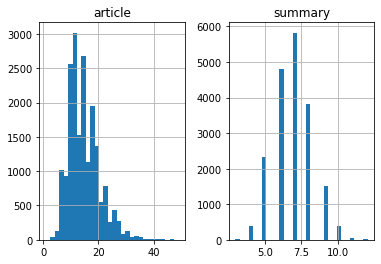

In [27]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in new_df['clean_article'] :
      text_word_count.append(len(i.split()))

for i in new_df['clean_summary'] :
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'article':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [28]:
print("max word in summary : ", max(summary_word_count))
print("max word in article : ", max(text_word_count))

print("min word in summary : ", min(summary_word_count))
print("min word in article : ", min(text_word_count))

max word in summary :  12
max word in article :  49
min word in summary :  3
min word in article :  1


In [29]:
max_len_text=50
max_len_summary=12
# from sklearn.model_selection import train_test_split
# x_tr,x_val,y_tr,y_val=train_test_split(new_df['clean_article'], new_df['clean_summary'],test_size=0.1,random_state=0,shuffle=True) 
x_tr = new_df['clean_article'][:8000]
x_val = new_df['clean_article'][8000:]
y_tr = new_df['clean_summary'][:8000]
y_val = new_df['clean_summary'][8000: ]

In [30]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [31]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [32]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [43]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 500)      10160500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [35]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [45]:
x_tr
y_tr[:,:-1]
y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]

array([[[ 2027],
        [  316],
        [  905],
        ...,
        [    0],
        [    0],
        [    0]],

       [[ 1572],
        [  448],
        [ 4503],
        ...,
        [    0],
        [    0],
        [    0]],

       [[ 4504],
        [ 4505],
        [    2],
        ...,
        [    0],
        [    0],
        [    0]],

       ...,

       [[ 1788],
        [ 4459],
        [10842],
        ...,
        [    0],
        [    0],
        [    0]],

       [[  180],
        [ 4465],
        [ 3901],
        ...,
        [    0],
        [    0],
        [    0]],

       [[10845],
        [ 4394],
        [ 3807],
        ...,
        [    0],
        [    0],
        [    0]]], dtype=int32)

In [46]:
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=10,
                  # callbacks=[es],
                  batch_size=64, 
                  validation_data=([x_val,y_val[:,:-1]], 
                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/10
125/125 [==============================] - 42s 234ms/step - loss: 4.2119 - val_loss: 3.2094
Epoch 2/10
125/125 [==============================] - 22s 174ms/step - loss: 3.6901 - val_loss: 3.0498
Epoch 3/10
125/125 [==============================] - 20s 159ms/step - loss: 3.5617 - val_loss: 2.9801
Epoch 4/10
125/125 [==============================] - 19s 154ms/step - loss: 3.4683 - val_loss: 2.9492
Epoch 5/10
125/125 [==============================] - 19s 155ms/step - loss: 3.3941 - val_loss: 2.9312
Epoch 6/10
125/125 [==============================] - 18s 147ms/step - loss: 3.3274 - val_loss: 2.9279
Epoch 7/10
125/125 [==============================] - 18s 145ms/step - loss: 3.2621 - val_loss: 2.8915
Epoch 8/10
125/125 [==============================] - 18s 144ms/step - loss: 3.1969 - val_loss: 2.8864
Epoch 9/10
125/125 [==============================] - 18s 143ms/step - loss: 3.1345 - val_loss: 2.8657
Epoch 10/10
125/125 [==============================] - 18s 145ms/step - l

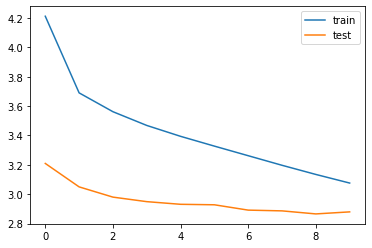

In [47]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [48]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

In [49]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [50]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [51]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [52]:
for i in range(20):
  print("Article:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Article: বিএনপি জোটের লাগাতার অবরোধের রাজধানীর নিউ মার্কেট এলাকায় হাতবোমা বিস্ফোরণে দুজন আহত 
Original summary: ঢাকার নীলক্ষেতে হাতবোমায় আহত ২ 
1/1 [==============================] - 1s 899ms/step
input_seq: [[   2    9  115   14   30   35 3574   69   71  314  820    5    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], e_out: [[[-8.96074693e-04 -9.44495760e-03  5.31460810e-03 ... -6.16290718e-02
   -1.69947483e-02  5.62443994e-02]
  [-4.89495369e-03  1.21906223e-02  1.95671227e-02 ... -2.39154056e-01
   -3.49114686e-02  2.39003360e-01]
  [-1.32820075e-02  6.77144378e-02  5.57363816e-02 ... -4.96905327e-01
   -3.24594453e-02  4.98636574e-01]
  ...
  [-3.81839201e-02  1.24227731e-02  1.99100927e-01 ... -9.98470247e-01
   -1.26179919e-01  9.89094436e-01]
  [-3.80466767e-02  1.24267442e-02  1.99929059e-01 ... -9.98466194e-01
   -1.23756245e-01 

In [53]:
print("Article:",seq2text(x_val[113]))
print("Original summary:",seq2summary(y_val[113]))
print("Predicted summary:",decode_sequence(x_val[113].reshape(1,max_len_text)))

Article: ইসলামিক স্টেটে আইএস সিরিয়ার ব্রিটিশ কিশোরকে আটক 
Original summary: ৩ ব্রিটিশ আটক 
1/1 [==============================] - 0s 32ms/step
input_seq: [[ 181 6042  191  921  696 3319   27    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], e_out: [[[-2.91005312e-03 -9.72777139e-03 -5.69597032e-05 ... -3.61248502e-03
   -5.19153243e-03  1.77944591e-03]
  [-8.59185960e-03 -1.37427012e-02  1.89573423e-03 ... -2.53334250e-02
   -1.22945672e-02  1.73656344e-02]
  [-1.86031405e-02 -5.36024058e-03  5.30645158e-03 ... -5.68823181e-02
   -1.48071451e-02  4.56202738e-02]
  ...
  [-4.27385010e-02  1.33246845e-02  1.71696335e-01 ... -9.98442113e-01
   -1.15566395e-01  9.86691773e-01]
  [-4.25168090e-02  1.32022751e-02  1.71135575e-01 ... -9.98448253e-01
   -1.14886701e-01  9.86714303e-01]
  [-4.23736759e-02  1.31222028e-02  1

####Calculate BLEU Score

In [54]:
#BLEU Score of Training set
#n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
one_gram = []
two_gram = []
for i in range(0,100):
  if(i==21):
    continue
  print(i)
  reference = seq2summary(y_val[i])
  candidate = decode_sequence(x_val[i].reshape(1, max_len_text))
  one_gram.append(sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
  two_gram.append(sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
# reference = seq2summary(y_val[1])
# candidate = decode_sequence(x_val[1].reshape(1, max_len_text))

print(reference)
print(candidate)

0
1/1 [==============================] - 0s 21ms/step
input_seq: [[   2    9  115   14   30   35 3574   69   71  314  820    5    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], e_out: [[[-8.96074693e-04 -9.44495760e-03  5.31460810e-03 ... -6.16290718e-02
   -1.69947483e-02  5.62443994e-02]
  [-4.89495369e-03  1.21906223e-02  1.95671227e-02 ... -2.39154056e-01
   -3.49114686e-02  2.39003360e-01]
  [-1.32820075e-02  6.77144378e-02  5.57363816e-02 ... -4.96905327e-01
   -3.24594453e-02  4.98636574e-01]
  ...
  [-3.81839201e-02  1.24227731e-02  1.99100927e-01 ... -9.98470247e-01
   -1.26179919e-01  9.89094436e-01]
  [-3.80466767e-02  1.24267442e-02  1.99929059e-01 ... -9.98466194e-01
   -1.23756245e-01  9.88797128e-01]
  [-3.79511081e-02  1.24090668e-02  2.00589716e-01 ... -9.98464465e-01
   -1.21387690e-01  9.88513172e-01]]] 
1/1 [===========

In [56]:
print("Individual 1-gram: ", np.average(one_gram))

Individual 1-gram:  0.39537534101095007


####Calculate ROUGH Score

In [57]:
!pip install rouge
from rouge import Rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
# Evaluate summarization using ROUGE metrics
def evaluate_summarization(reference_summary, generated_summary):
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary, reference_summary)
    return scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']

In [59]:
f1_score_1 = []
f1_score_2 = []
f1_score_l = []
for i in range(0,100):
  if(i==21):
    continue
  reference = seq2summary(y_val[i])
  candidate = decode_sequence(x_val[i].reshape(1, max_len_text))
  score_1, score_2, score_l = evaluate_summarization(reference, candidate)
  f1_score_1.append(score_1)
  f1_score_2.append(score_2)
  f1_score_l.append(score_l)


print("ROUGE-1 F1-score:", np.average(f1_score_1))
print("ROUGE-2 F1-score:", np.average(f1_score_2))
print("ROUGE-L F1-score:", np.average(f1_score_l))

1/1 [==============================] - 0s 23ms/step
input_seq: [[   2    9  115   14   30   35 3574   69   71  314  820    5    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], e_out: [[[-8.96074693e-04 -9.44495760e-03  5.31460810e-03 ... -6.16290718e-02
   -1.69947483e-02  5.62443994e-02]
  [-4.89495369e-03  1.21906223e-02  1.95671227e-02 ... -2.39154056e-01
   -3.49114686e-02  2.39003360e-01]
  [-1.32820075e-02  6.77144378e-02  5.57363816e-02 ... -4.96905327e-01
   -3.24594453e-02  4.98636574e-01]
  ...
  [-3.81839201e-02  1.24227731e-02  1.99100927e-01 ... -9.98470247e-01
   -1.26179919e-01  9.89094436e-01]
  [-3.80466767e-02  1.24267442e-02  1.99929059e-01 ... -9.98466194e-01
   -1.23756245e-01  9.88797128e-01]
  [-3.79511081e-02  1.24090668e-02  2.00589716e-01 ... -9.98464465e-01
   -1.21387690e-01  9.88513172e-01]]] 
1/1 [=============